In [244]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
import scipy.signal as signal

from scipy.fftpack import ifftn, fftn
import numpy.linalg as la

%matplotlib inline

In [245]:
def motion_psf(size, theta):
    """
    Sets up a convolution/deconvolution kernel based on kernel size and rotation angle

    Inputs:

        size: int  , denotes the size of the kernel
        theta: float, angle of the rotation in degrees. positive values are counter-clockwise
                        rotation. Negative values are clockwise.
    
    Outputs:

        kernel: n x n, numpy array of the motion blur kernel. n must be odd 

    """

    # n needs to be odd
    n = size if (size%2 == 1) else size + 1

    half_n = n//2         

    kernel = np.zeros((n,n)).astype('float32')

    # fills in a horizontal line across the middle
    kernel[half_n,half_n:] = 1

    # rotate the kernel to the desired angle
    center = (half_n ,half_n)

    rotation = cv2.getRotationMatrix2D(center, theta, 1.0)

    kernel = cv2.warpAffine(kernel, rotation, (n,n))

    
    #this was to see what the kernel looked like, might have a use for this still
    #plt.imshow(kernel, cmap = 'gray')
    #plt.show()
    

    return kernel

def focus_psf(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    which approximates out of focus blur
    """

    n = l if (l%2 == 1) else l + 1 


    ax = np.arange(-n // 2 + 1., n // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))

    return kernel

def convolve(image, kernel):
    """
    Inputs:

         image: a NxM array,    A grayscale image represented as an numpy array
        kernel:    a KxK array,    A kernel that we will convovlve with our image.
                                 K is odd. If it isn't someone did something very wrong
    
    Outputs:

        convolved_image: a PxP array,     Our padded image array that's been convolved with 
                                        the kernel.

    """

    # Save the spatial dimensions of the image and the kernel
    image_height, image_width   = image.shape
    kernel_height, kernel_width = kernel.shape

    # pad the image 
    pad = (kernel_width -1) /2
    
    proto_convolve = cv2.copyMakeBorder(image, pad, pad, pad, pad,
                                            cv2.BORDER_REPLICATE)
    
    convolved_image = np.zeros_like(proto_convolve, dtype = "float32")

    # loop over the proto convolution, while sliding our kernel
    # We're going left to right then top to bottom

    # Top to bottom
    for y in xrange(pad, image_height + pad):

        # Left to right
        for x in range(pad, image_width + pad):

            # extract a region of interest(roi) to convolve
            roi = proto_convolve[ y-pad:y+pad+1, x-pad:x+pad+1]

            # perform the convolution using the kernel
            # Element wise multiply and then sum the submatrix
            conv_val = (roi * kernel).sum()
        
            # store the value in the output in the convolved image output
            convolved_image[y,x] = conv_val
        

    # lastly we must rescale the image to be values between 0-255
    convolved_image = convolved_image / np.amax(convolved_image)
    convolved_image =(convolved_image).astype('float32')

    image_to_return = convolved_image[pad:image_height+pad, pad:image_width+pad]

    return image_to_return

def deconvolve(convolved_image, PSF):
    """
    Inputs:

        convolved_image:
                    PSF:
                epsilon:
    Outputs:

        deconvolved_image:

    """

    # create the full sized array with the kernel in it
    #    create the zeros array
    new_kern = np.zeros_like(convolved_image).astype('float32')

    # add in the kernel
    new_kern[:PSF.shape[0], :PSF.shape[1]] = PSF

    plt.imshow(new_kern,cmap='gray')
    plt.title('PADDED PSF')
    plt.show()

    # use the FFT on the convolved image and kernel    
    imag_fft = np.fft.fftn(convolved_image)
    kern_fft = np.fft.fftn(new_kern)
    
    # once in the image is in the FFT we can obtain the formula latent_image = blurred_image / PSF
    # to obtain our deblurred image
    deconvolved_image = np.abs(np.fft.ifftn(imag_fft/kern_fft))
    
    # the image will have shifted during the FFT so we shift it accordingly
    deconvolved_image = np.roll(deconvolved_image, PSF.shape[0]/2, axis = 0)
    deconvolved_image = np.roll(deconvolved_image, PSF.shape[1], axis = 1)

    return deconvolved_image

def add_noise(image,n=300):
    """
        adds salt and pepper noise to the image

    Inputs:

        image: an NxM numpy array of the image to be blurred
        n      : an integer control how much noise is added. The larger n is the less noise there will be

    Outputs:

        noisy_image: an NxM numpy array representing the image with salt and pepper noise added
    """
    noisy_image = image.copy()

    noise_vec = [(np.random.randint(0,image.shape[0]), np.random.randint(0,image.shape[1])) for k in xrange(image.shape[0] * image.shape[1] / n) ]

    for noise in noise_vec:
        noisy_image[noise] = np.random.rand()

    return noisy_image

In [246]:
def convolve2(star, psf):
    star_fft = np.fft.fftn(star)
    psf_fft = np.fft.fftn(psf)
    matrix = np.fft.ifftn(star_fft*psf_fft) 
    a = matrix/np.amax(matrix)
    return a.real

def deconvolve2(star, psf):
    star_fft = np.fft.fftn(star)
    psf_fft = np.fft.fftn(psf)
    matrix = np.fft.ifftn(star_fft/psf_fft) 
    a = matrix/np.amax(matrix)
    return a.real

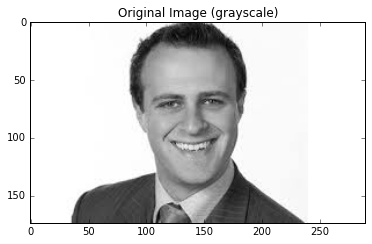

In [247]:
#load in the image and display it
path = 'index.jpeg'
image = cv2.imread(path, 0)/255.
plt.imshow(image, cmap = 'gray')
plt.title('Original Image (grayscale)')
plt.show()

In [347]:
def variational_calculus(f, k):
    m, n = f.shape
    time_steps = 50
    delta_t = .001
    eps = .0000002
    lda = 1.
    
    k_padded = np.zeros_like(f).astype('float32')
    k_padded[:k.shape[0], :k.shape[1]] = k[::-1,::-1]
    
    k_pad = np.zeros_like(f).astype('float32')
    k_pad[:k.shape[0], :k.shape[1]] = k
    fft_k_padded = fftn(k_padded)
    
    def rhs(u):
        ux = (np.roll(u,-1,axis=1) - np.roll(u,1,axis=1))/2
        uy = (np.roll(u,-1,axis=0) - np.roll(u,1,axis=0))/2

        uxx = np.roll(u,-1,axis=1) - 2*u + np.roll(u,1,axis=1)
        uyy = np.roll(u,-1,axis=0) - 2*u + np.roll(u,1,axis=0)

        uxy = (np.roll(ux,-1,axis=0) - np.roll(ux,1,axis=0))/2.
        
        gross = (uxx*uy*uy + uyy*ux*ux - 2*ux*uy*uxy)/((eps + ux*ux + uy*uy)**1.5)
        #kstar = ifftn(fftn(np.roll(np.roll(convolve2(u,k_pad),k.shape[0],axis=0),k.shape[1]/2,axis=1) - f) * fft_k_padded).real
        convolved = np.roll(convolve2(u,k_pad),k.shape[0]/2,axis = 0)
        kstar = ifftn(fftn(convolved - f) * fft_k_padded).real
        
        u -= delta_t*(lda*kstar - gross)
        
        plt.imshow(kstar,cmap='gray')
        plt.title('kstar')
        plt.show()
        plt.imshow(ifftn(fftn(convolve2(u,k_pad) - f)).real ,cmap ='gray')
        plt.title('half_kstar')
        plt.show()
        plt.imshow(convolve2(u,k_pad),cmap = 'gray')
        plt.title('convolve')
        plt.show()
        plt.imshow(kstar,cmap='gray')
        plt.show()

    u0 = f.copy()
    u1 = f.copy()
    iteration = 0
    while iteration < time_steps:
        rhs(u1)
        if la.norm(np.abs((u0 - u1))) < 1e-5:
            print 'break:',la.norm(np.abs((u0 - u1))) 
            break
        u0 = u1.copy()
        iteration+=1
        
    plt.imshow(u1, cmap='gray')
    plt.show()

    return u1

In [343]:
noisy_image = add_noise(image)
#plt.imshow(noisy_image,cmap='gray')
#plt.show()

In [344]:
kernel = motion_psf(15,30)
blurry_image = convolve(image, kernel)
#plt.imshow(blurry_image,cmap='gray')
#plt.show()


k_pad = np.zeros_like(image).astype('float32')
k_pad[:kernel.shape[0], :kernel.shape[1]] = kernel
blurry_image2 = convolve2(image, k_pad).real
#plt.imshow(blurry_image2,cmap='gray')
#plt.show()
dif = blurry_image-blurry_image2
#plt.imshow(dif,cmap='gray')
#plt.show()

In [345]:
noisy_blurry_image = add_noise(blurry_image)
#plt.imshow(noisy_blurry_image,cmap='gray')
#plt.show()

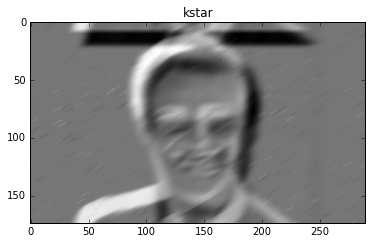

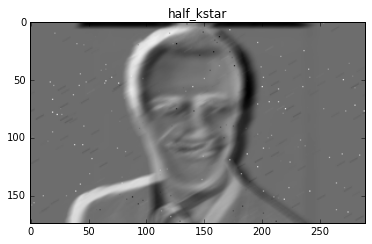

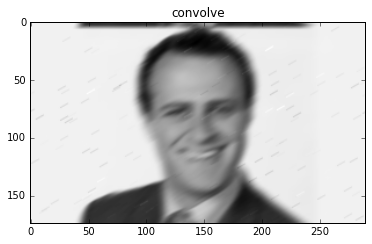

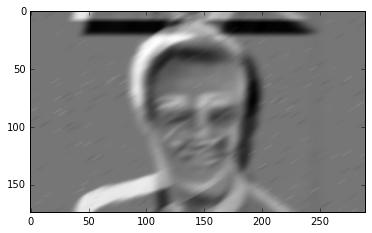

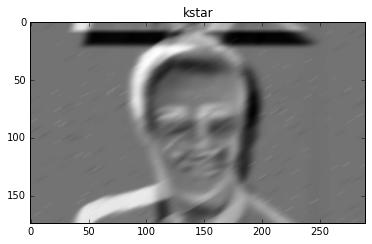

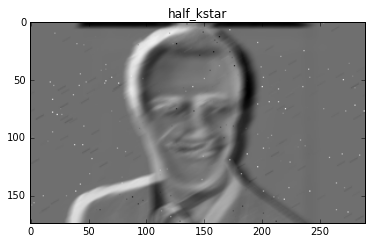

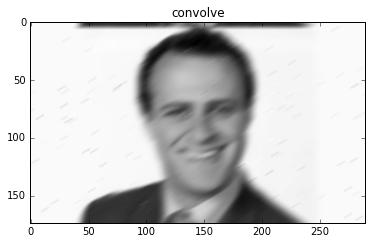

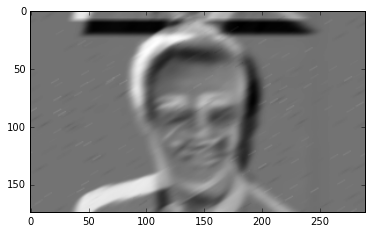

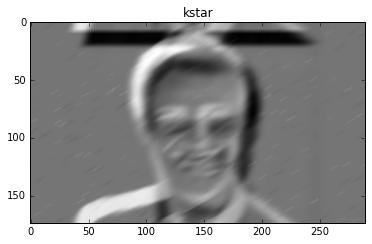

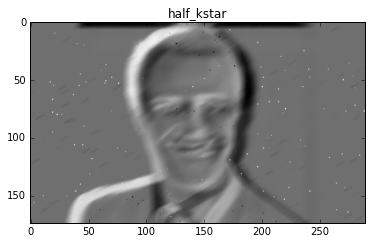

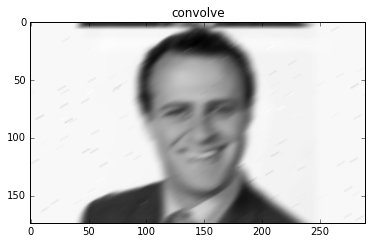

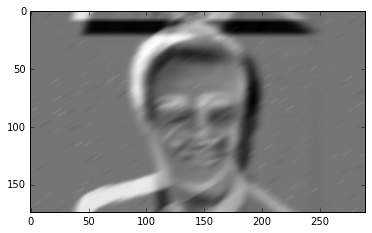

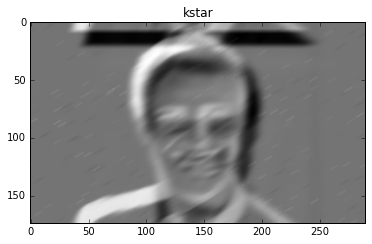

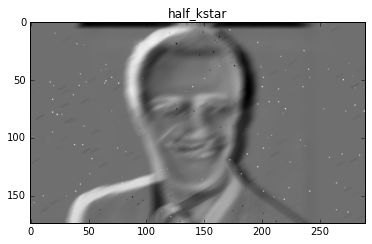

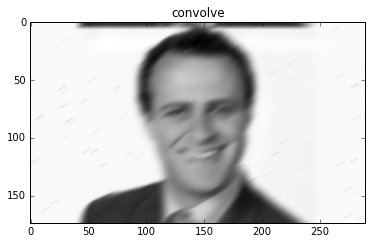

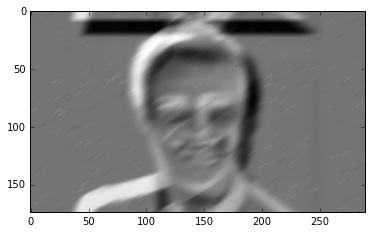

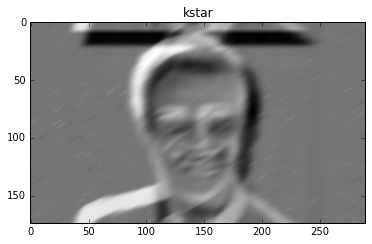

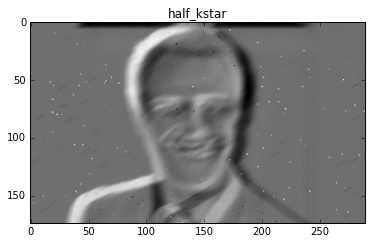

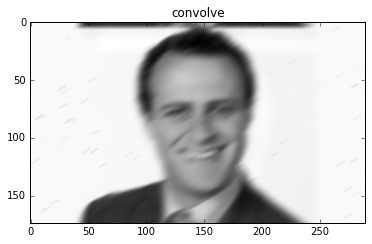

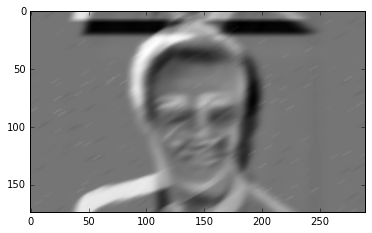

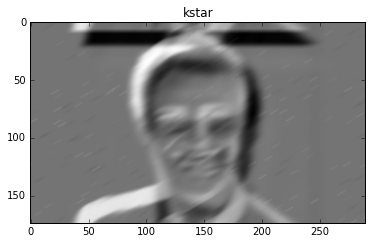

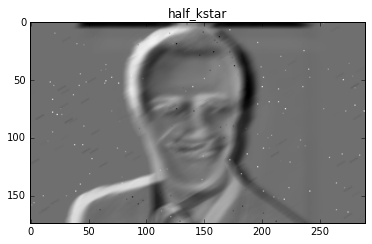

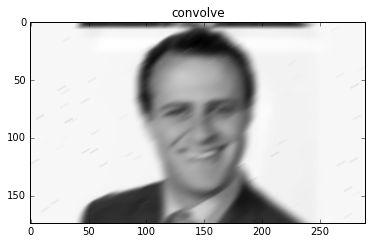

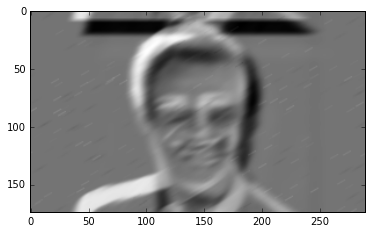

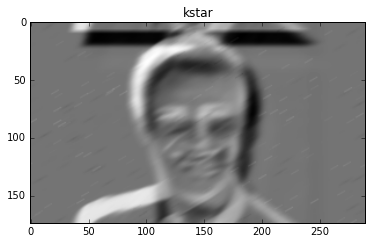

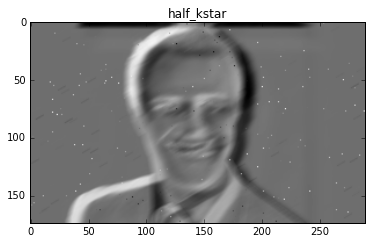

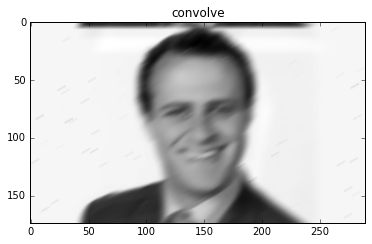

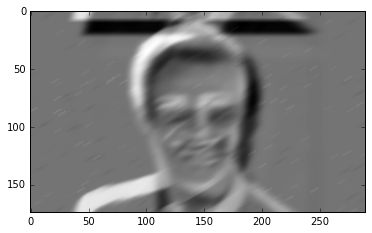

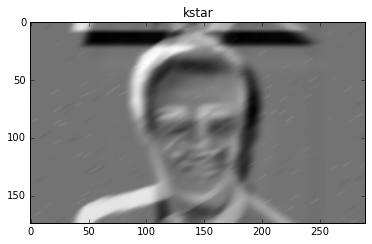

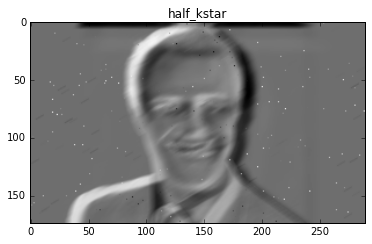

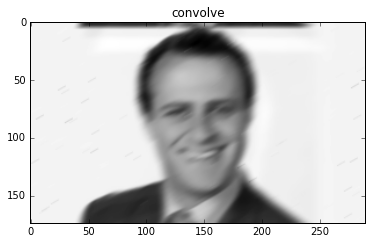

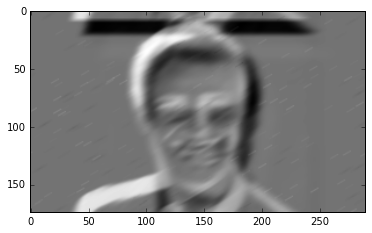

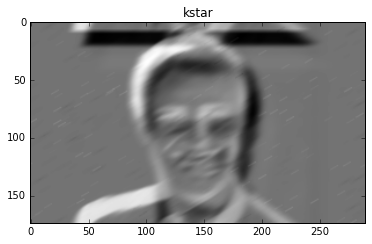

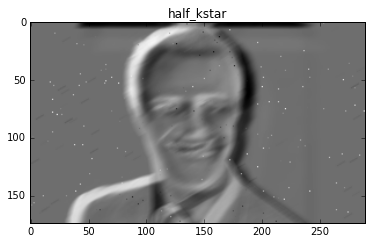

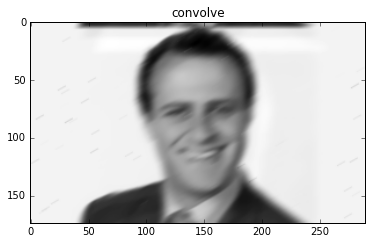

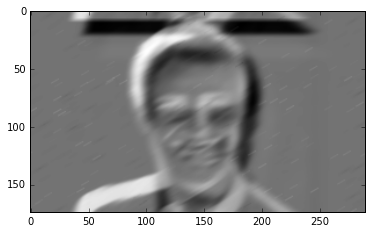

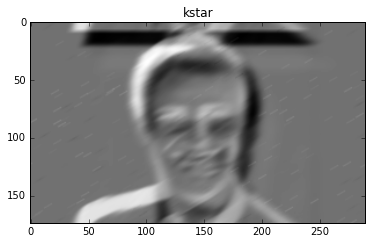

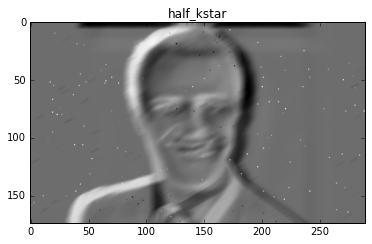

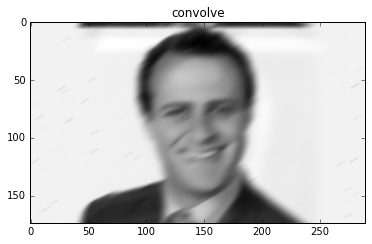

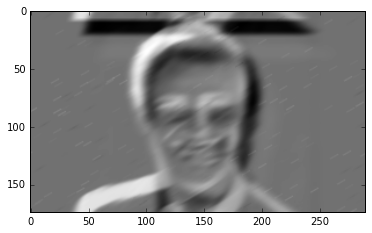

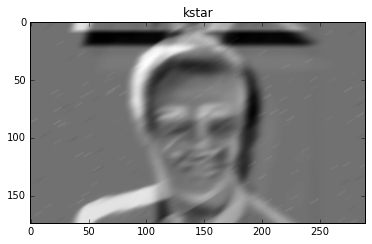

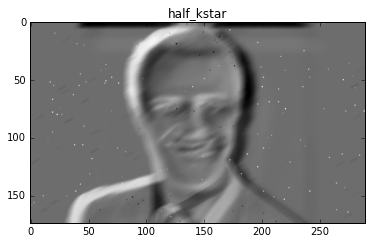

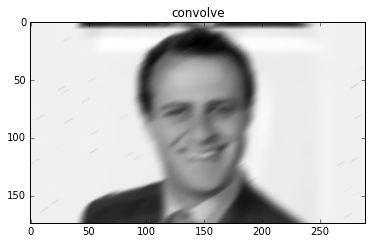

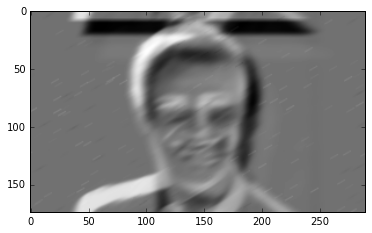

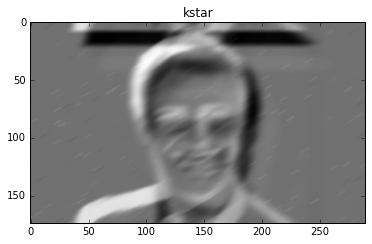

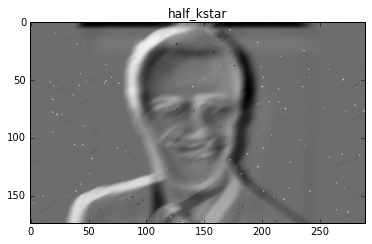

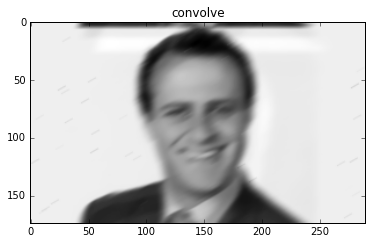

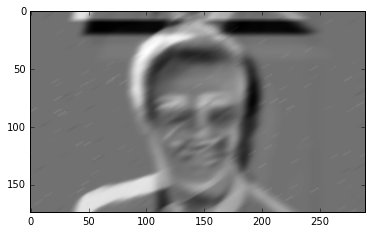

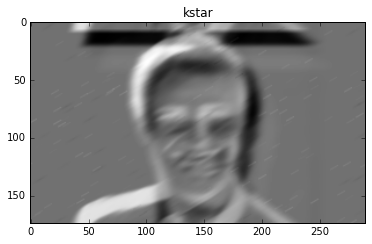

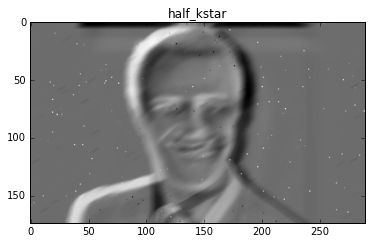

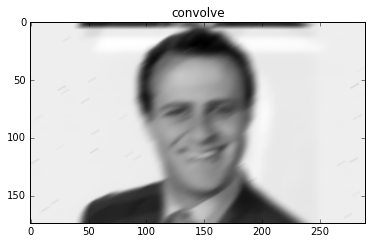

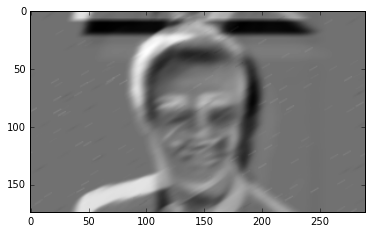

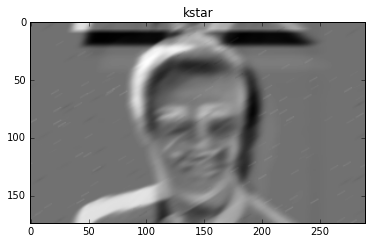

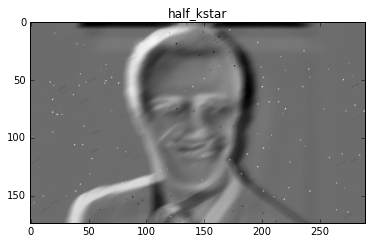

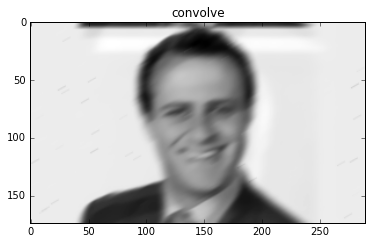

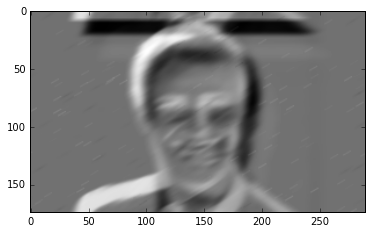

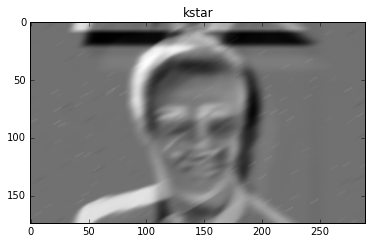

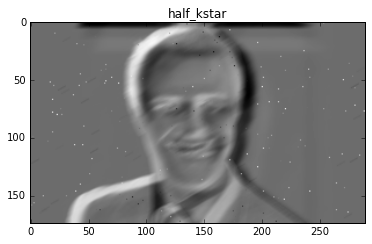

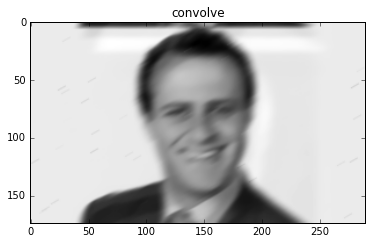

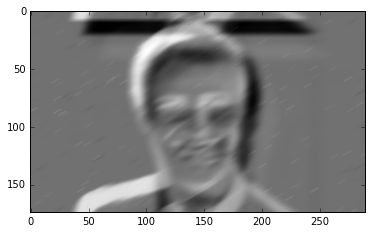

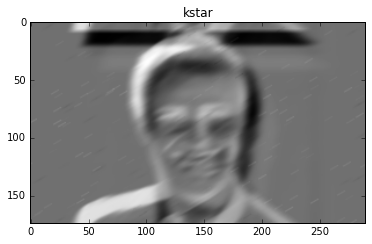

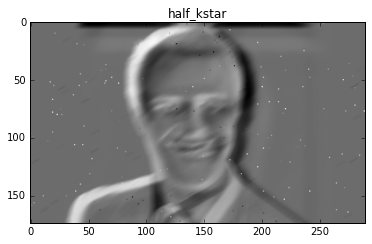

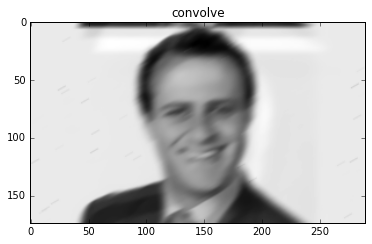

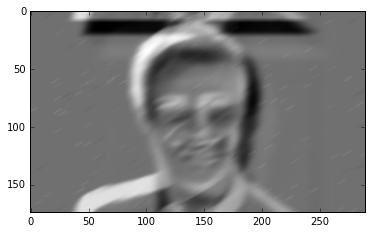

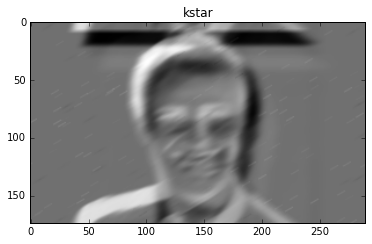

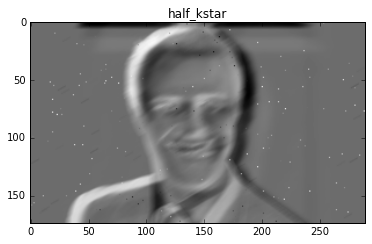

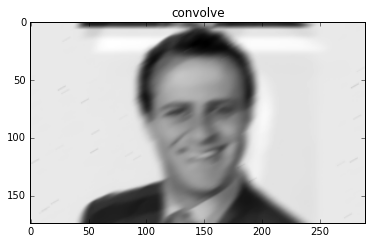

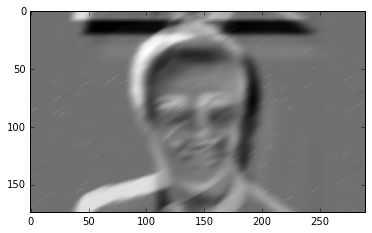

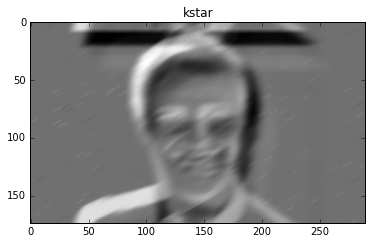

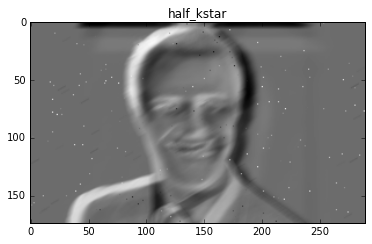

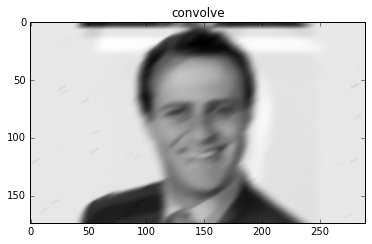

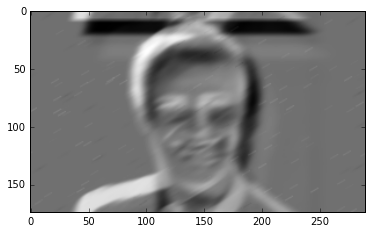

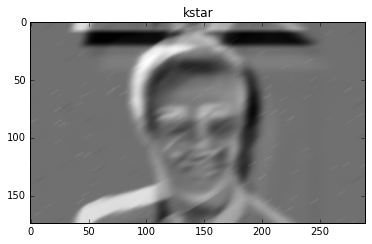

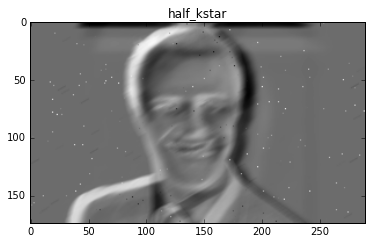

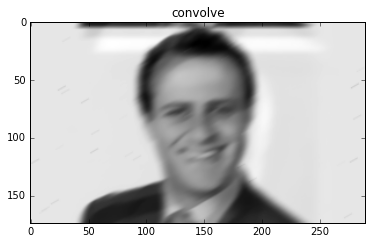

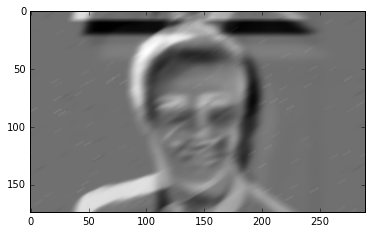

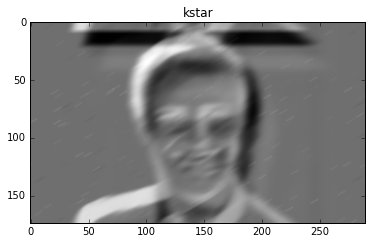

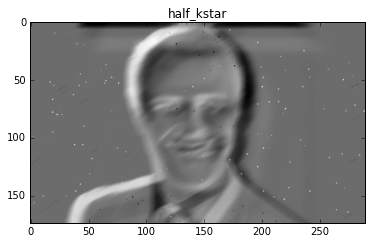

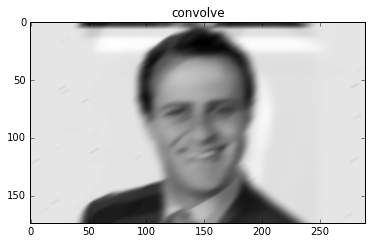

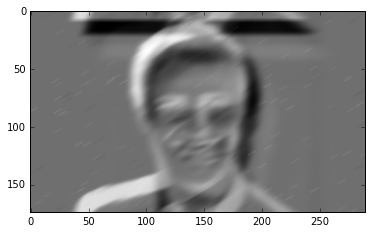

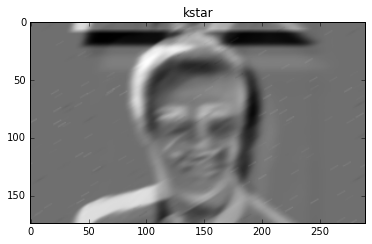

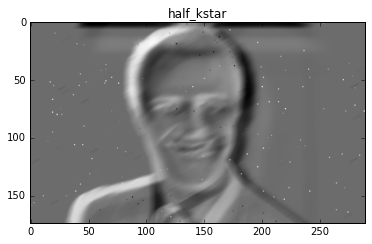

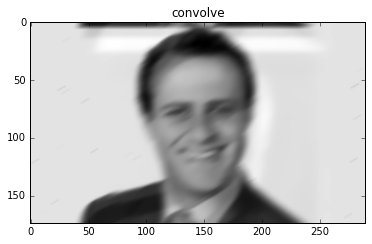

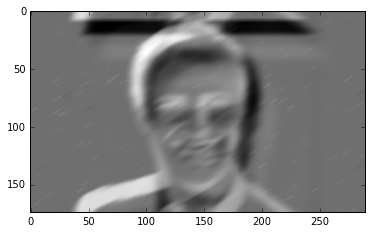

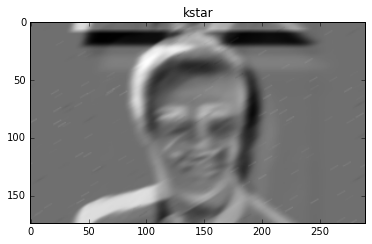

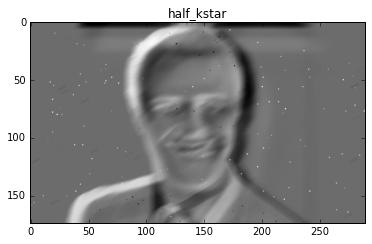

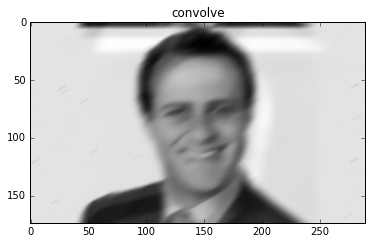

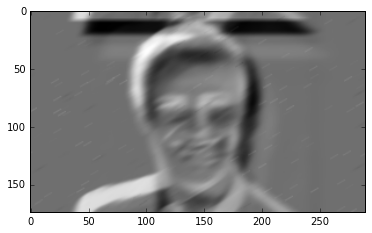

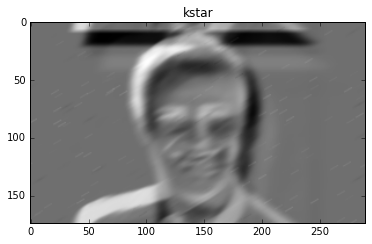

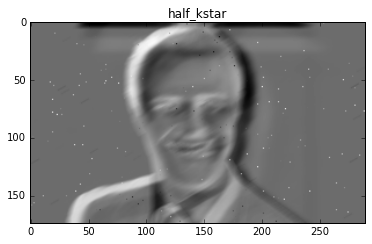

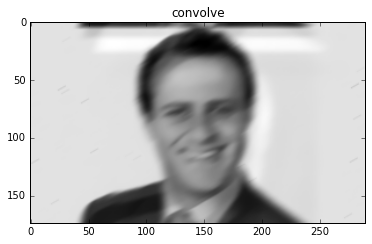

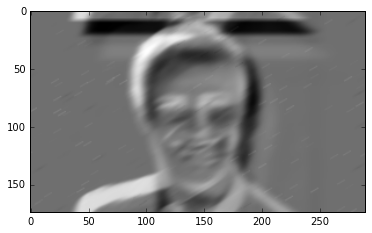

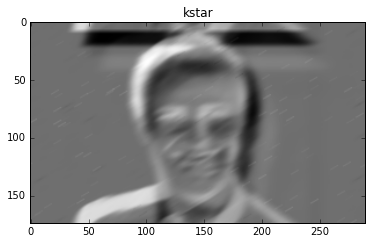

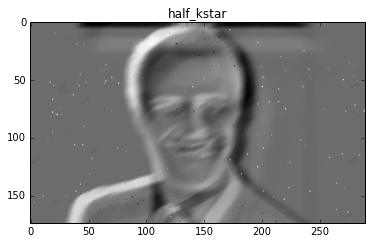

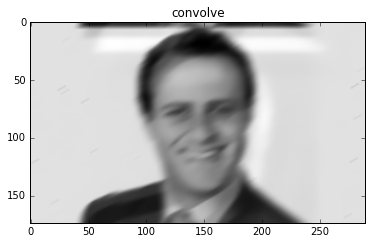

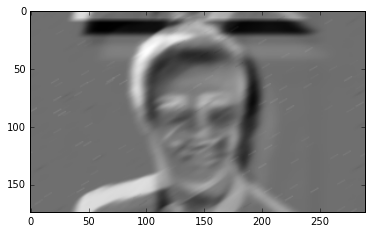

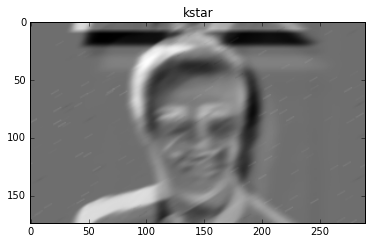

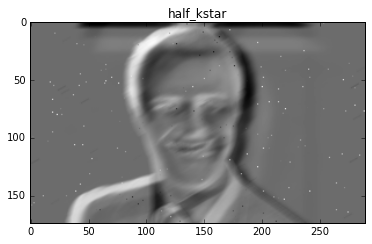

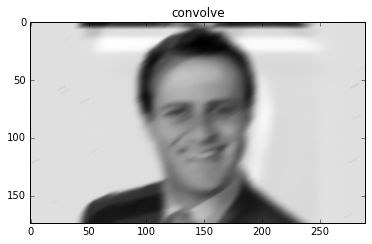

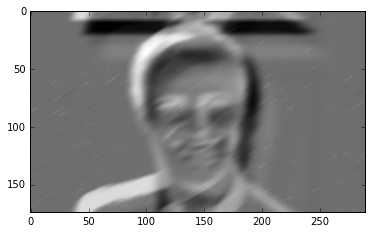

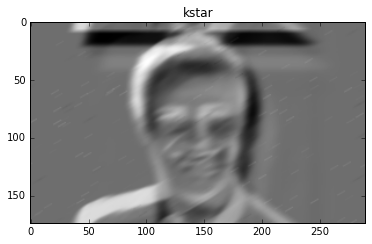

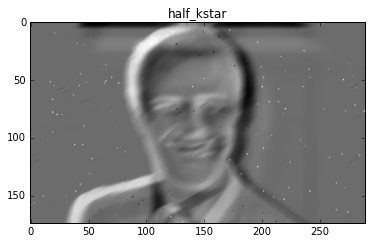

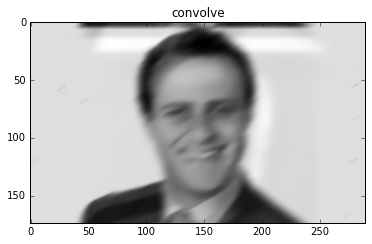

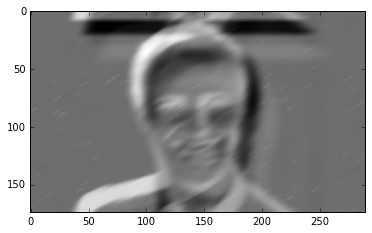

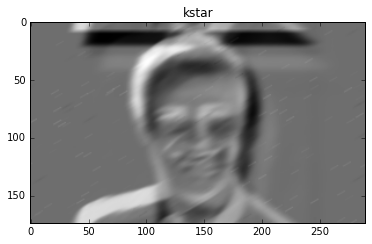

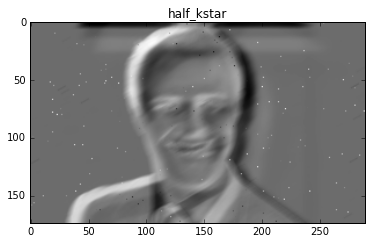

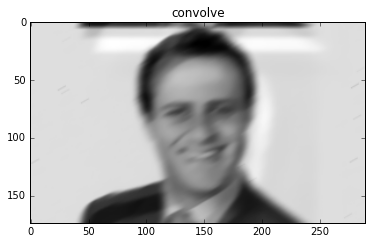

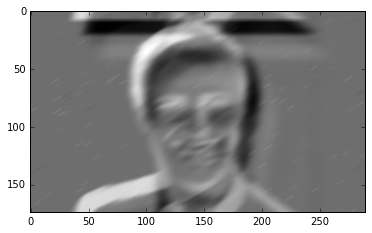

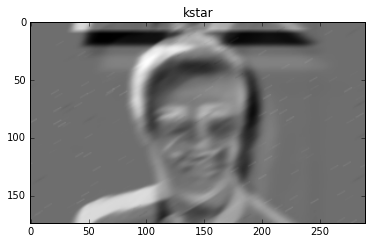

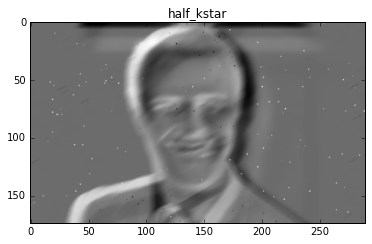

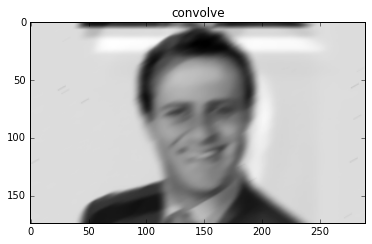

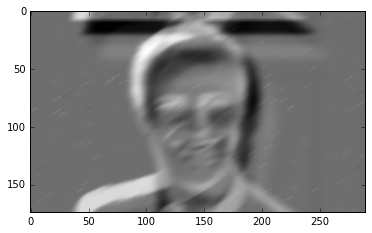

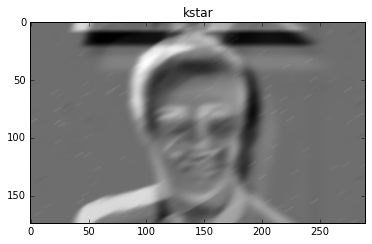

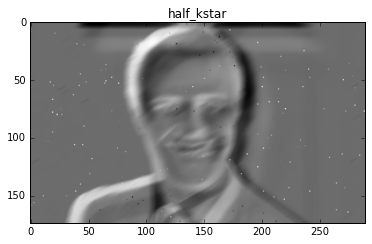

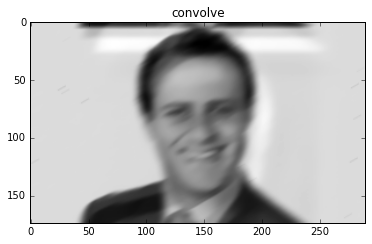

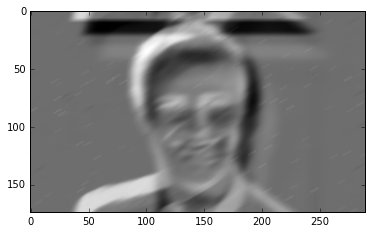

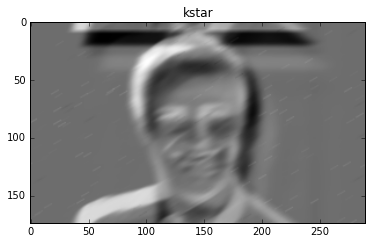

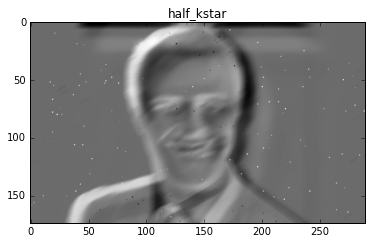

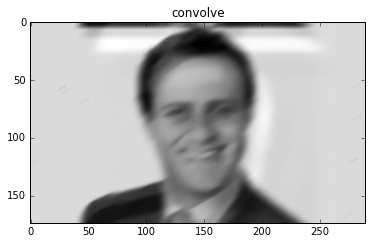

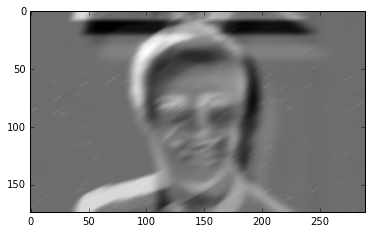

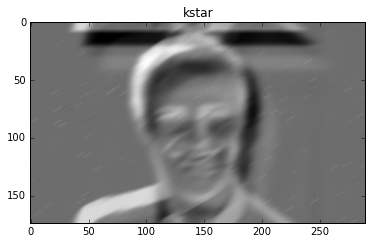

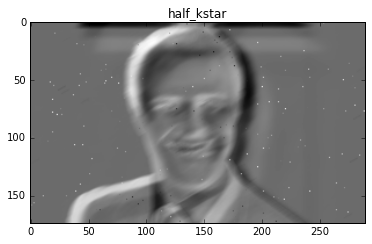

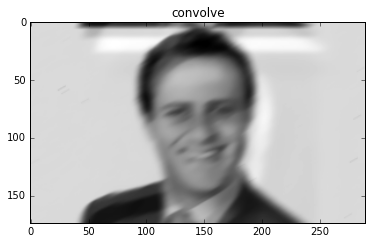

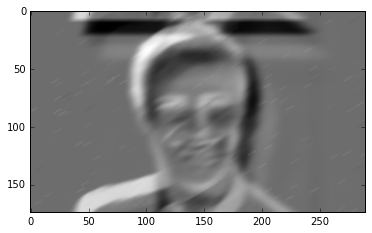

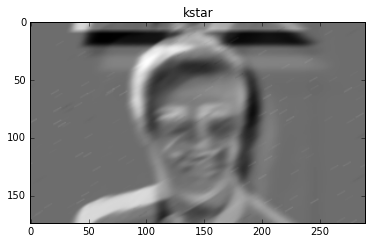

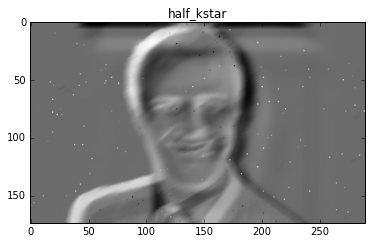

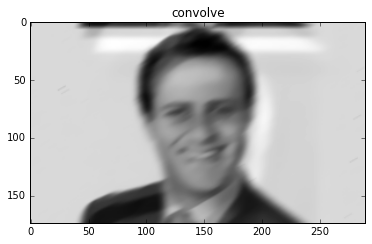

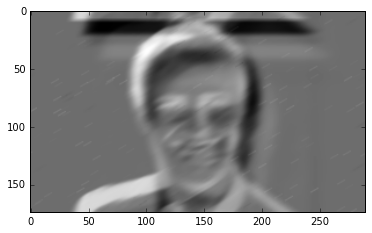

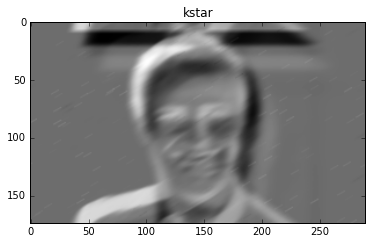

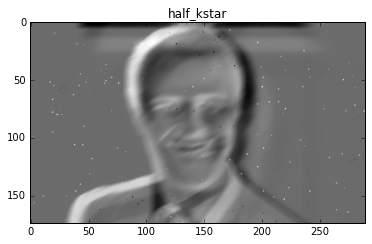

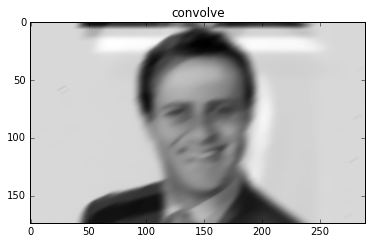

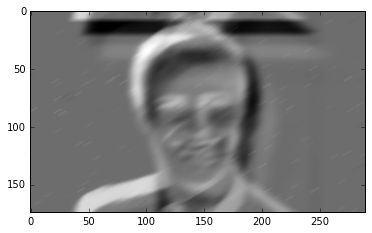

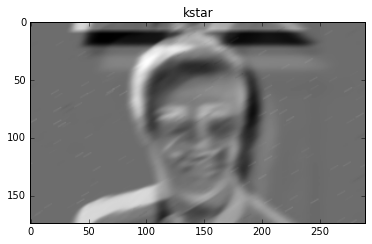

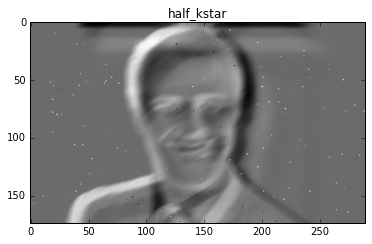

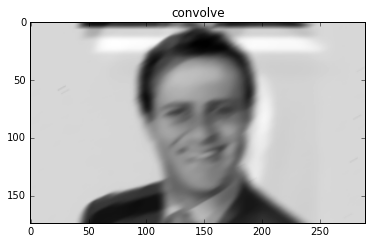

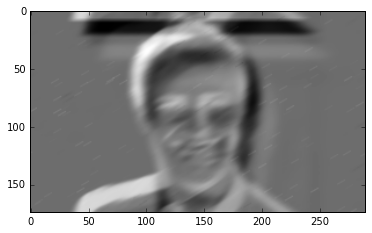

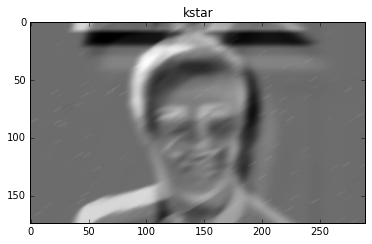

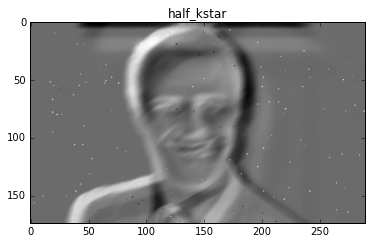

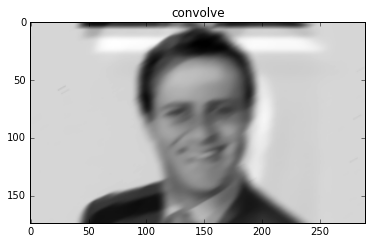

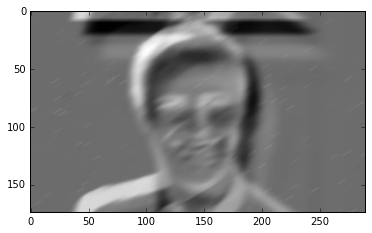

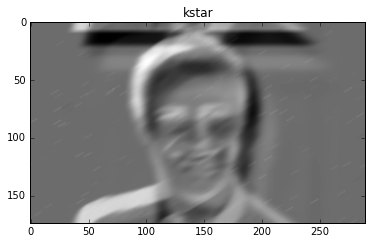

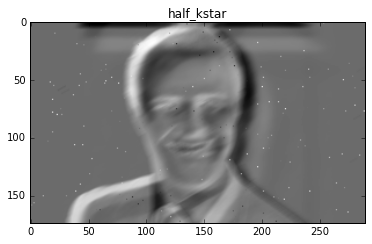

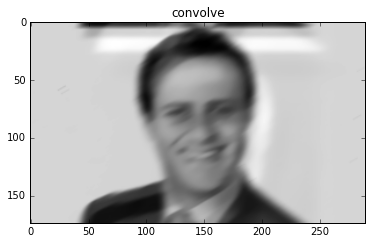

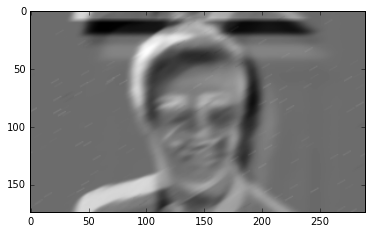

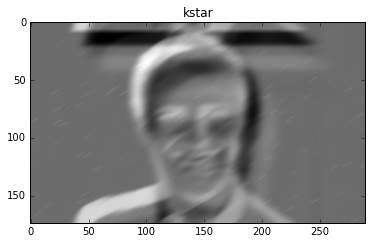

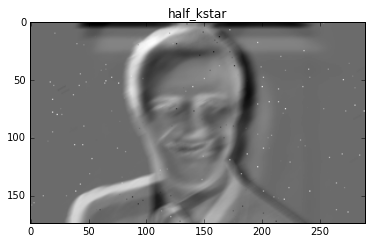

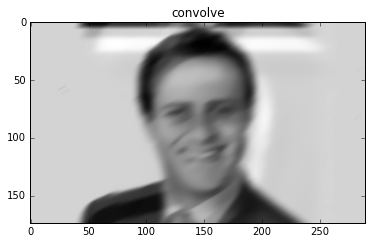

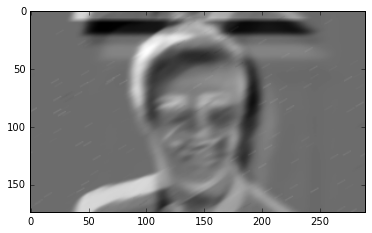

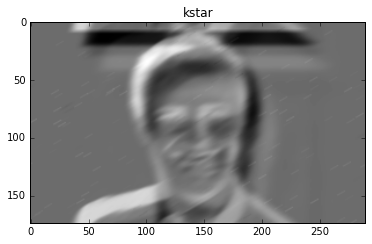

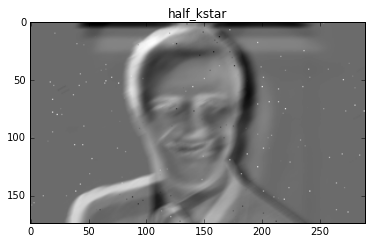

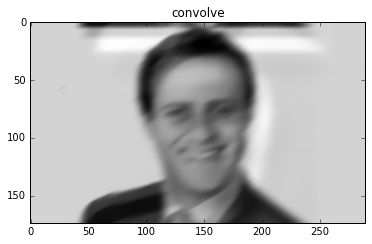

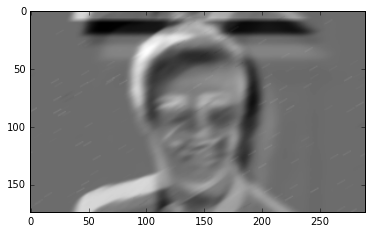

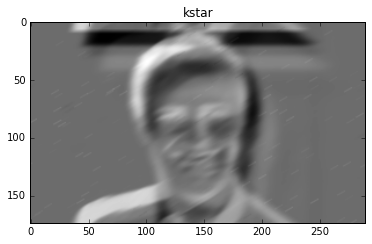

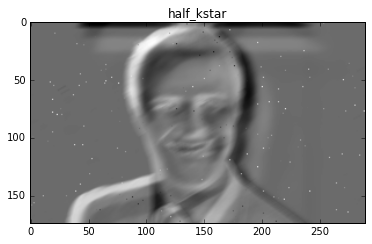

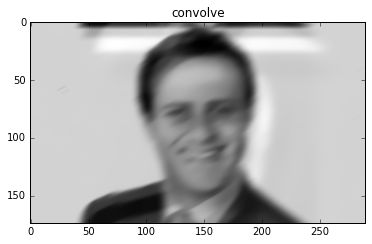

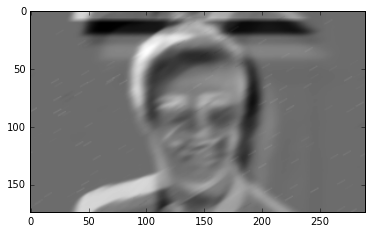

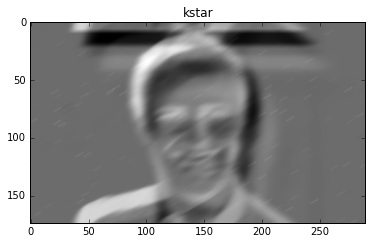

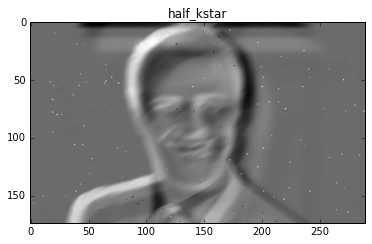

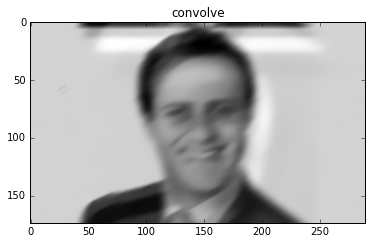

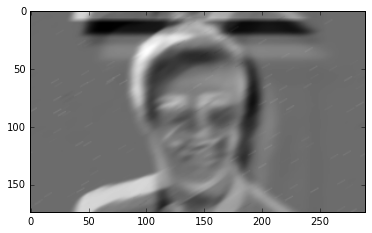

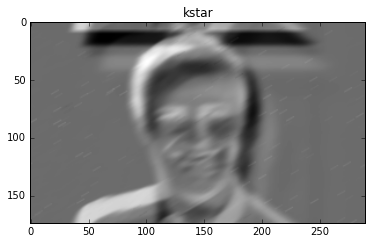

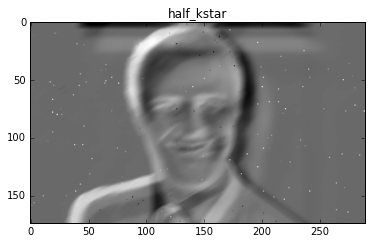

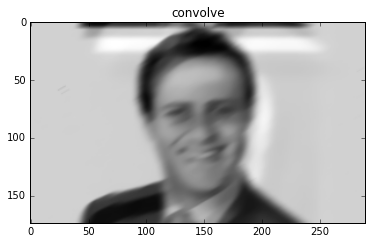

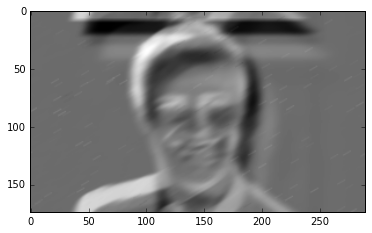

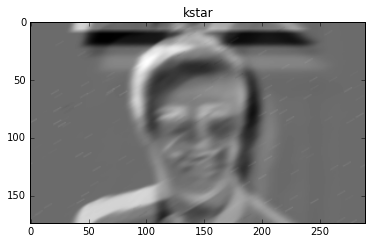

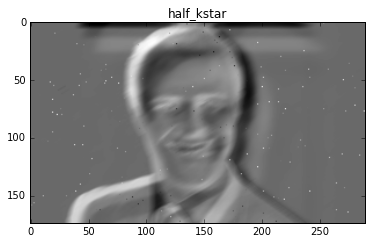

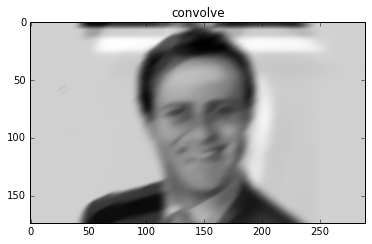

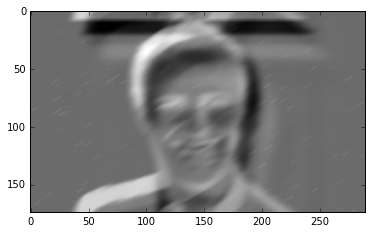

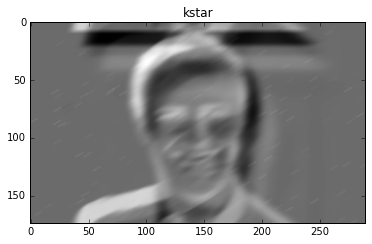

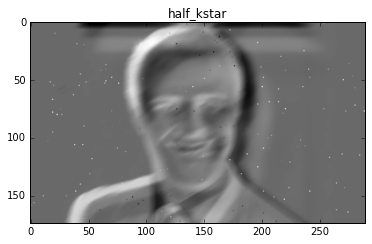

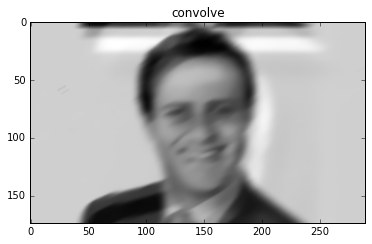

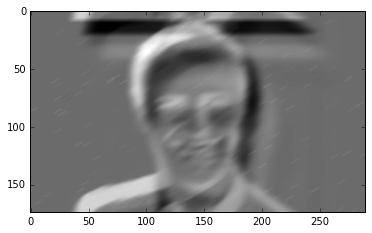

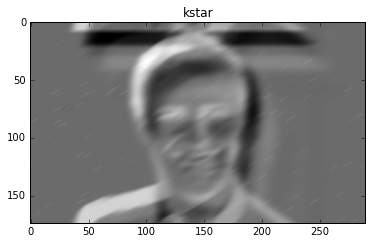

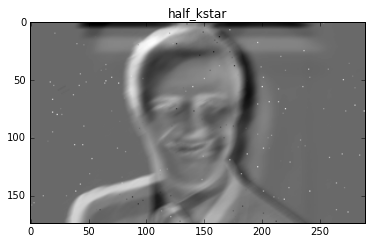

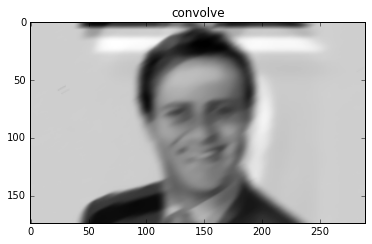

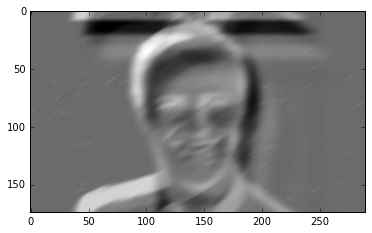

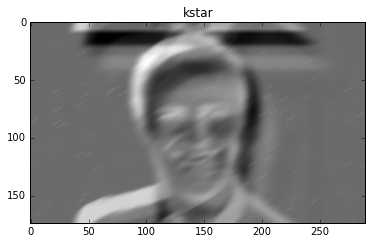

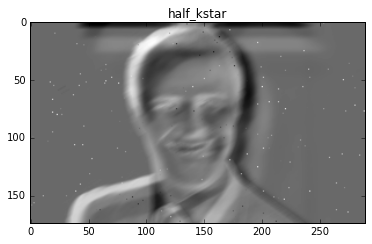

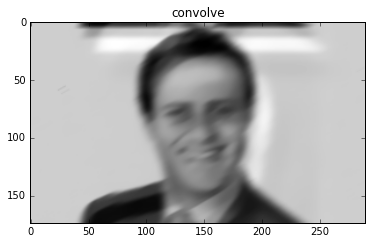

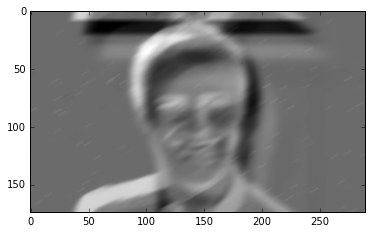

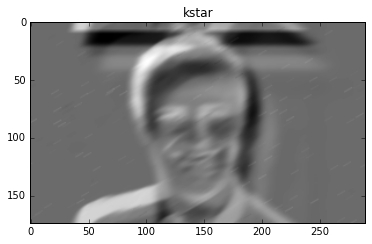

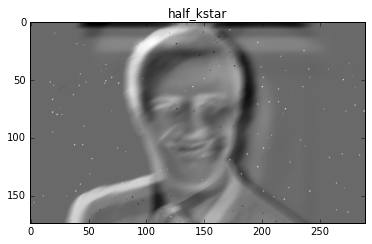

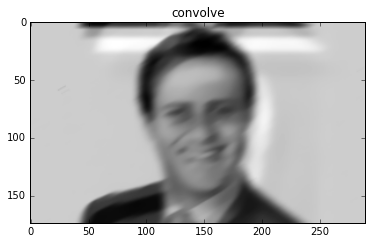

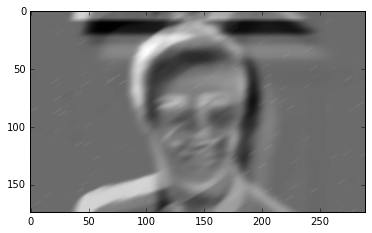

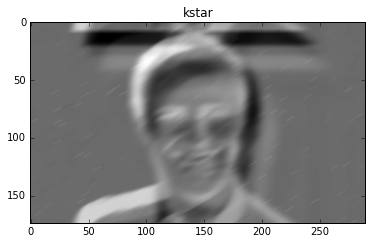

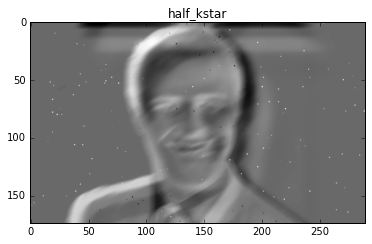

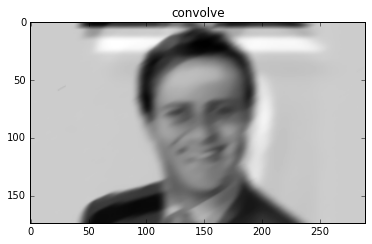

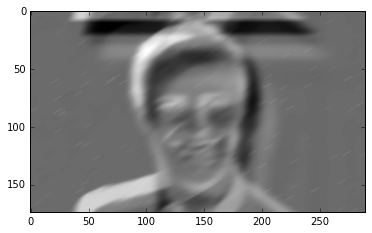

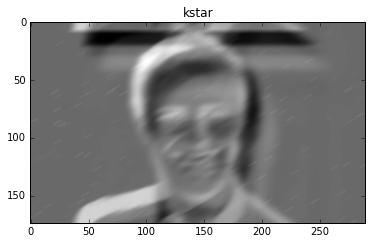

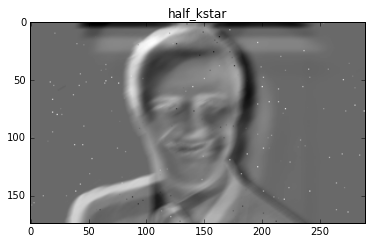

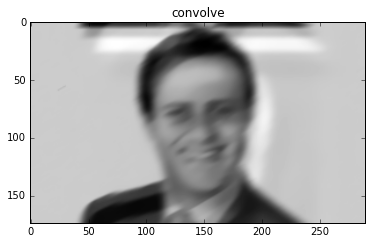

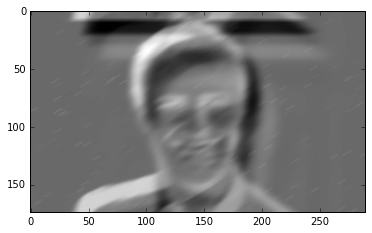

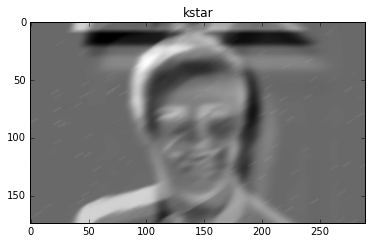

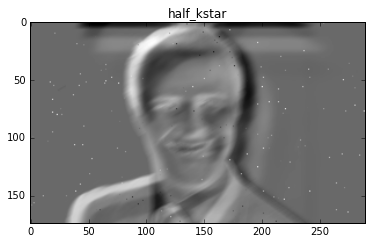

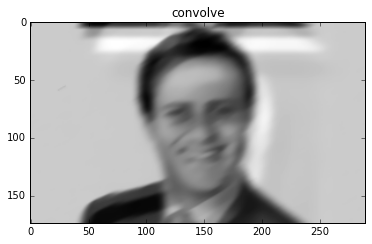

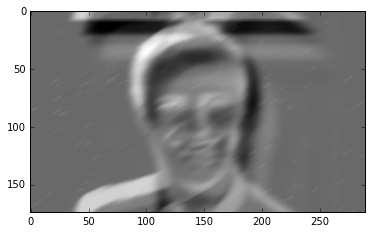

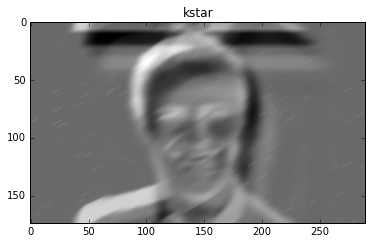

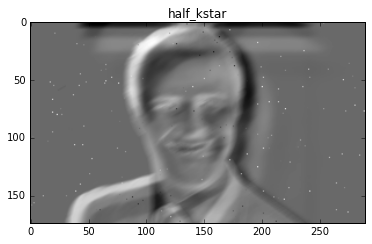

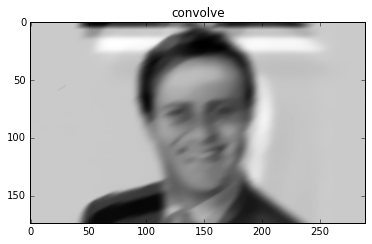

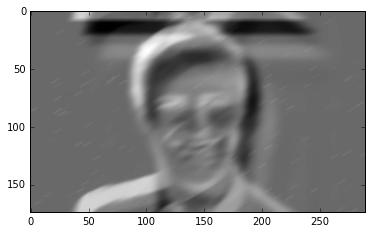

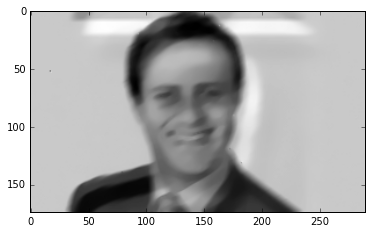

array([[ 1.04629087,  1.04626274,  1.04624832, ...,  1.04638505,
         1.046363  ,  1.04632735],
       [ 1.04625726,  1.04624891,  1.04624534, ...,  1.04632103,
         1.046296  ,  1.04627252],
       [ 1.04625285,  1.0462507 ,  1.04624581, ...,  1.04627359,
         1.04626048,  1.04625452],
       ..., 
       [ 1.04546773,  1.04761088,  1.04517674, ...,  1.04910374,
         1.04288089,  1.04913533],
       [ 1.0463922 ,  1.04636526,  1.04630244, ...,  1.04639423,
         1.04639089,  1.0463686 ],
       [ 1.04635394,  1.04630768,  1.04627144, ...,  1.04640603,
         1.04642165,  1.04639888]], dtype=float32)

In [348]:
variational_calculus(noisy_blurry_image, kernel)